In [16]:
import os
from keras.preprocessing.image import ImageDataGenerator
train_dir = os.path.join('mask/Face Mask Dataset', 'Train')
train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150, 150),class_mode='categorical')

Found 2000 images belonging to 2 classes.


In [17]:
from keras.preprocessing.image import ImageDataGenerator
#train_datagen = ImageDataGenerator(rescale=1./255)
#train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=train_generator = train_datagen.flow_from_directory(train_dir,target_size=(150, 150),class_mode='categorical')
validation_dir = os.path.join('mask/Face Mask Dataset', 'Validation')
validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(validation_dir,target_size=(150, 150),class_mode='categorical')

Found 800 images belonging to 2 classes.


In [18]:
from keras import layers
from keras import models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(225, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

In [19]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [21]:
history = model.fit_generator(train_generator,epochs=10,validation_data=validation_generator)

C:\Users\hp\AppData\Local\Temp\ipykernel_16984\638197317.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,epochs=10,validation_data=validation_generator)


Epoch 1/10
63/63 [==============================] - 68s 1s/step - loss: 0.1440 - acc: 0.9475 - val_loss: 0.1252 - val_acc: 0.9575
Epoch 2/10
63/63 [==============================] - 69s 1s/step - loss: 0.0986 - acc: 0.9655 - val_loss: 0.1046 - val_acc: 0.9688
Epoch 3/10
63/63 [==============================] - 62s 986ms/step - loss: 0.1135 - acc: 0.9630 - val_loss: 0.1049 - val_acc: 0.9700
Epoch 4/10
63/63 [==============================] - 66s 1s/step - loss: 0.0704 - acc: 0.9715 - val_loss: 0.0719 - val_acc: 0.9762
Epoch 5/10
63/63 [==============================] - 41s 650ms/step - loss: 0.0553 - acc: 0.9800 - val_loss: 0.0727 - val_acc: 0.9750
Epoch 6/10
63/63 [==============================] - 41s 658ms/step - loss: 0.0773 - acc: 0.9770 - val_loss: 0.0999 - val_acc: 0.9775
Epoch 7/10
63/63 [==============================] - 42s 664ms/step - loss: 0.0776 - acc: 0.9755 - val_loss: 0.1002 - val_acc: 0.9787
Epoch 8/10
63/63 [==============================] - 43s 678ms/step - loss: 0.0

In [22]:
import joblib
joblib.dump(model, 'mask_detection_model.joblib')

['mask_detection_model.joblib']

In [25]:
import cv2
import numpy as np
import joblib  # Import joblib for loading the model
from tensorflow.keras.models import load_model

# Load the Haar Cascade Classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load your trained CNN model for mask detection
# Replace 'mask_detection_model.joblib' with the path to your saved model file
model = joblib.load('mask_detection_model.joblib')

# Define the labels for mask and no-mask
labels = {0: 'With Mask', 1: 'Without Mask'}

# Open a video capture stream or use an image
cap = cv2.VideoCapture(0)  # 0 for webcam, or provide a video file path

while True:
    # Read a frame from the video stream
    ret, frame = cap.read()

    # Convert the frame to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Loop through the detected faces
    for (x, y, w, h) in faces:
        # Extract the face ROI
        face_roi = gray[y:y + h, x:x + w]

        # Resize the face ROI to (150, 150) to match the model's input shape
        face_roi = cv2.resize(face_roi, (150, 150))

        # Convert the grayscale image to RGB by duplicating channels
        face_roi_rgb = cv2.cvtColor(face_roi, cv2.COLOR_GRAY2RGB)

        # Normalize the pixel values
        face_roi_rgb = face_roi_rgb / 255.0

        # Expand the dimensions to create a batch of size 1
        face_roi_rgb = np.expand_dims(face_roi_rgb, axis=0)

        # Make predictions using the CNN model
        prediction = model.predict(face_roi_rgb)
        label_index = np.argmax(prediction)
        label = labels[label_index]
        confidence = prediction[0][label_index]

        # Draw a rectangle around the face and display the label and confidence
        color = (0, 255, 0) if label_index == 0 else (0, 0, 255)
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        cv2.putText(frame, f'{label}: {confidence:.2f}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    # Display the frame
    cv2.imshow('Mask Detection', frame)

    # Break the loop when the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 161ms/step


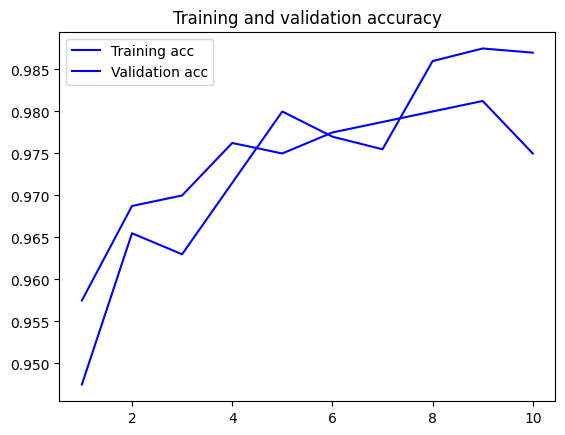

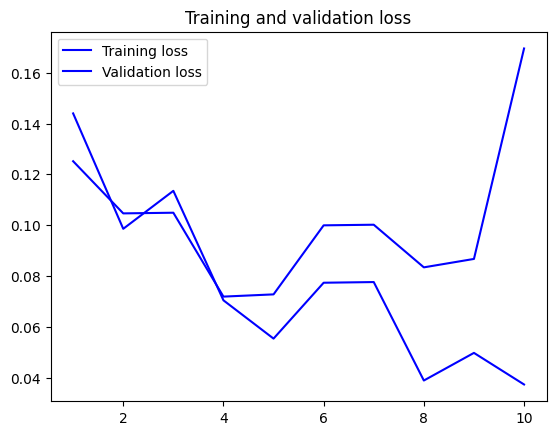

In [28]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()